### remove very low MIC value

In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [77]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [25]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [26]:
df2 = df[df['MIC'] >= 1e-3]

In [27]:
df2

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
706,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131


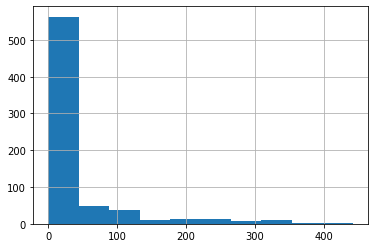

In [28]:
df2['MIC'].hist()

In [29]:
df2['pIC50'] = df2['MIC'].apply(lambda x: -np.log(x*1e-6))

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
706,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579


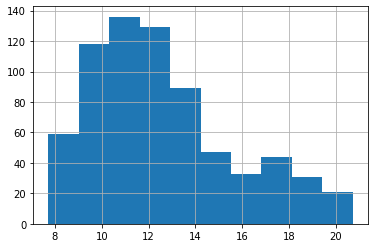

In [31]:
df2['pIC50'].hist()

In [32]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [33]:
dipep_freq = reduce_by_kmer_frequency(df2, kmer=2)

In [34]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1130.57sequence/s]


In [35]:
physicochemical_prop = get_physicochemical_properties(df2)

In [36]:
X = pd.concat([dipep_freq, physicochemical_prop[['turn']]], axis=1)

In [37]:
y = df2[['pIC50', 'MIC']]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [40]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [41]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [43]:
svr = SVR(C=10, gamma=10)
cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

_ = svr.fit(X_train, y_train_pmic)
y_pred = svr.predict(X_test)

print(np.std(y_test_pmic), np.std(y_pred))

[-13.19063984 -11.6954193  -11.83070764 -13.08399312 -13.26039897] -12.61223177445778
2.7423101563508783 2.1456047966562584


In [280]:
df['MIC'].argmin()

693

In [281]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [282]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [283]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [284]:
gg = list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

In [285]:
sorted(gg, key=lambda x:x[5])

[(10.9141, 10.9148, 0.006627639854659558, 18.2, 18.1868, 0.07230849579253662),
 (16.5489, 16.5166, 0.19488961964986096, 0.065, 0.0671, 3.2777780523370366),
 (12.075, 12.0334, 0.34486220531300327, 5.7, 5.9424, 4.252146494292989),
 (11.3306, 11.2776, 0.46808707905671193, 12.0, 12.6536, 5.446875766994644),
 (15.182, 15.2606, 0.5175848019258664, 0.255, 0.2357, 7.557165367913814),
 (11.6183, 11.7063, 0.7578943047595089, 9.0, 8.2414, 8.428887316042438),
 (17.356, 17.4467, 0.5229740744752192, 0.029, 0.0265, 8.676973530496557),
 (11.5129, 11.6195, 0.9257090832671947, 10.0, 8.9891, 10.109344823221473),
 (10.8198, 10.7185, 0.93573448169883, 20.0, 22.1309, 10.654704466816689),
 (18.9315, 19.0505, 0.6287467172241942, 0.006, 0.0053, 11.221992043347777),
 (9.2103, 9.3436, 1.447060549531569, 100.0, 87.5221, 12.477930537654629),
 (18.3254, 18.4734, 0.8076837256150646, 0.011, 0.0095, 13.757840254104574),
 (12.0238, 12.1982, 1.4510532943915981, 6.0, 5.0394, 16.009881946260467),
 (12.0238, 12.2077, 1.530

In [286]:
ape_mic.mean()

1729.5271538010716

### Leave one out CV

In [79]:
loo = LeaveOneOut()

In [80]:
from tqdm import tqdm

In [83]:
result_df = pd.DataFrame(columns = list(df2.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    svr = SVR(C=10, gamma=10)
    _ = svr.fit(X_train, y_train_pmic)
    y_pred_pmic = svr.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df2.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df2.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

707it [02:38,  4.47it/s]


In [84]:
result_df#.to_csv("../results/SVM_pMIC_to_MIC_removed_less_than_1e-6_rbf_c_10_gamma_10.csv", index=False)

,Sequence,pIC50,y_pred_pmic,ape_pmic,MIC,y_pred_mic,ape_mic
0,AAQRRGRVGRNPNQVGD,7.724200675886576,8.474085931823693,9.708257040474232,442.0,208.80997464182514,52.75792428917983
0,HRILARIRQMMT,7.739015761671717,10.960233933747979,41.62309874118206,435.5,17.37924406254798,96.00935842421401
0,RNPSQVGD,7.867475568783628,8.486220732283247,7.864595931567431,383.0,206.291419254525,46.138010638505214
0,RVGRNPNQVGD,7.891254760549742,8.209481564085173,4.032651500827506,374.0,272.06173130660727,27.256221575773456
0,AAQRRGRIGRNPSQVGD,7.934977571563574,8.993424552192252,13.339004062491792,358.0,124.22395257445072,65.30057190657801
...,...,...,...,...,...,...,...
0,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,20.46090157247892,12.995384886398604,36.48674355641231,0.0013,2.270785192731984,174575.78405630647
0,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,15.977030210679716,11.75705663949729,26.412753281029786,0.11515,7.833848673833259,6703.168626863448
0,CFPYITRPGTYHDWWYTRKNRQ,15.01948336229021,11.374792348433369,24.266420661363476,0.3,11.481283749753528,3727.0945832511757
0,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,18.297578546818382,18.41232944776213,0.6271370862004042,0.011309999999999999,0.010083862655429536,10.841178997086322


In [85]:
result_df['ape_pmic'].astype('float').mean()

11.636250146496206

In [86]:
result_df['ape_mic'].astype('float').mean()

3381.3542621919096

In [113]:
logMIC = np.log(result_df['MIC'].astype('float'))
pred_logMIC = np.log(result_df['y_pred_mic'].astype('float'))

In [114]:
mean_squared_error(logMIC, pred_logMIC)**0.5

1.993313517614353

In [115]:
r2_score(logMIC, pred_logMIC)

0.5750494973613198

In [106]:
import matplotlib.pyplot as plt

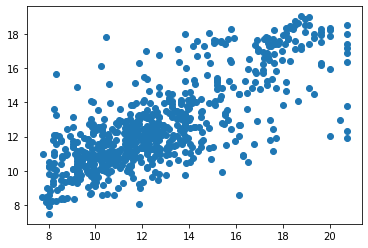

In [111]:
plt.scatter(x=result_df['pIC50'].values.astype('float'), y=result_df['y_pred_pmic'].values.astype('float'))

In [287]:
params2 = ['molecular_weight', 'aromaticity', 'instability_index',
          'isoelectric_point', 'helix', 'turn', 'sheet', 'with_reduced_cysteines',
          'with_disulfid_bridges', 'gravy', 'net_charge_at_pH7point4']

In [288]:
prop2 = []
for seq in df2.Sequence:
    X = ProteinAnalysis(seq)
    molecular_weight = X.molecular_weight()
    aromaticity = X.aromaticity()
    instability_index = X.instability_index()
    isoelectric_point = X.isoelectric_point()
    sec_struc = X.secondary_structure_fraction()
    helix = sec_struc[0]
    turn = sec_struc[1]
    sheet = sec_struc[2]
    epsilon_prot = X.molar_extinction_coefficient()
    with_reduced_cysteines = epsilon_prot[0]
    with_disulfid_bridges = epsilon_prot[1]
    gravy = X.gravy() # hydrophobicity related
    # flexibility = X.flexibility()
    # X.protein_scale()
    net_charge_at_pH7point4 = X.charge_at_pH(7.4)

    prop2.append([seq, molecular_weight, aromaticity, instability_index, isoelectric_point, helix, turn, sheet,
                 with_reduced_cysteines, with_disulfid_bridges, gravy, net_charge_at_pH7point4])
prop2 = pd.DataFrame(prop2, columns=["Sequence"]+params2)

In [289]:
prop2

,Sequence,molecular_weight,aromaticity,instability_index,isoelectric_point,helix,turn,sheet,with_reduced_cysteines,with_disulfid_bridges,gravy,net_charge_at_pH7point4
0,AAQRRGRVGRNPNQVGD,1850.9960,0.000000,24.817647,11.999968,0.117647,0.352941,0.117647,0,0,-1.547059,2.609418
1,HRILARIRQMMT,1525.8875,0.000000,36.466667,11.999968,0.250000,0.000000,0.333333,0,0,-0.208333,2.594004
2,RNPSQVGD,871.8950,0.000000,48.687500,6.087706,0.125000,0.500000,0.000000,0,0,-1.700000,-0.440856
3,RVGRNPNQVGD,1211.2883,0.000000,-11.454545,9.598972,0.181818,0.454545,0.000000,0,0,-1.545455,0.559118
4,AAQRRGRIGRNPSQVGD,1837.9973,0.000000,56.905882,11.999968,0.117647,0.352941,0.117647,0,0,-1.370588,2.609418
...,...,...,...,...,...,...,...,...,...,...,...,...
702,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,4331.9284,0.083333,22.725000,4.356391,0.388889,0.083333,0.444444,2980,2980,-0.433333,-5.755126
703,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,3336.9618,0.100000,-1.326667,9.408790,0.233333,0.266667,0.066667,5500,5750,-0.066667,4.466476
704,CFPYITRPGTYHDWWYTRKNRQ,2889.2103,0.272727,33.700000,9.625146,0.318182,0.181818,0.000000,15470,15470,-1.486364,2.559925
705,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,4450.8237,0.138889,62.650000,4.300688,0.361111,0.194444,0.361111,17990,17990,-0.875000,-5.406266


In [302]:
prop2.merge(result_df,on=['Sequence'],how='left')#.to_csv("../results/SVM_pMIC_to_MIC_removed_less_than_1e-6_rbf_c_10_gamma_10_dipep_turns.csv", index=False)

### Test with external sequence from https://www.biorxiv.org/content/10.1101/2021.04.07.438720v1.full.pdf

In [90]:
test = pd.DataFrame([['AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS', 2.09995035],
                     ['AAGMGFFGAR', 1.108873537],
                     ['AEVAPAPAAAAPAKAPKKKAAAKPKKAGPS', 0.301029996],
                     ['AGLQFPVGRIGRLLRK', 0.799340549],
                     ['VLNENAAR', 128]], columns=["Sequence", "logMIC"])

In [91]:
"A G L Q F P V G R I G R L L R K".replace(" ", "")

'AGLQFPVGRIGRLLRK'

In [92]:
test

,Sequence,logMIC
0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,2.099950
1,AAGMGFFGAR,1.108874
2,AEVAPAPAAAAPAKAPKKKAAAKPKKAGPS,0.301030
3,AGLQFPVGRIGRLLRK,0.799341
4,VLNENAAR,128.000000


In [93]:
test_dipep = reduce_by_kmer_frequency(test, kmer=2)

In [94]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

test_protvec = convert_sequences_to_avg_vectors(test['Sequence'], uniprot_embedding, kmer=3)
test_protvec = test_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 5/5 [00:00<00:00, 886.03sequence/s]


In [95]:
test_physicochemical_prop = get_physicochemical_properties(test)

In [96]:
test_X = pd.concat([test_dipep, test_physicochemical_prop[['turn']]], axis=1)

In [97]:
test_X

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YY,turn
0,0.281250,0.0,0.0,0.000000,0.03125,0.031250,0.0,0.0,0.031250,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212121
1,0.111111,0.0,0.0,0.000000,0.00000,0.111111,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000
2,0.172414,0.0,0.0,0.034483,0.00000,0.034483,0.0,0.0,0.068966,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266667
3,0.000000,0.0,0.0,0.000000,0.00000,0.066667,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
4,0.142857,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000


In [98]:
y_pred = svr.predict(test_X)

In [99]:
y_pred

array([ 9.56985628, 11.49879018,  9.64696197,  9.66795884, 10.58266034])

In [100]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [101]:
y_pred_mic

array([69.80141464, 10.14235663, 64.62159131, 63.27888566, 25.35181223])

In [102]:
np.log(y_pred_mic)

array([4.24565428, 2.31672038, 4.16854859, 4.14755171, 3.23285022])

In [103]:
test['logMIC'].values

array([  2.09995035,   1.10887354,   0.30103   ,   0.79934055,
       128.        ])